In [ ]:
#Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import all packages

import pandas as pd
import numpy as np
from datetime import timedelta, datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import plotly.graph_objects as go

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_excel('drive/My Drive/nawell data preprosecing/data_new.xlsx')

In [ ]:
date_time = pd.to_datetime(df.pop('datetime'), format='%d.%m.%Y')

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day'] = np.log10(timestamp_s * (2 * np.pi / day))
df['Year'] = np.log10(timestamp_s * (2 * np.pi / year))

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

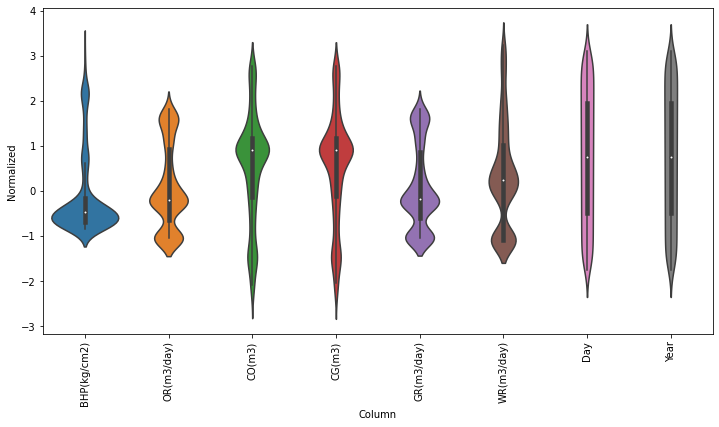

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='BHP(kg/cm2)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [day]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 200
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]
Label column name(s): None

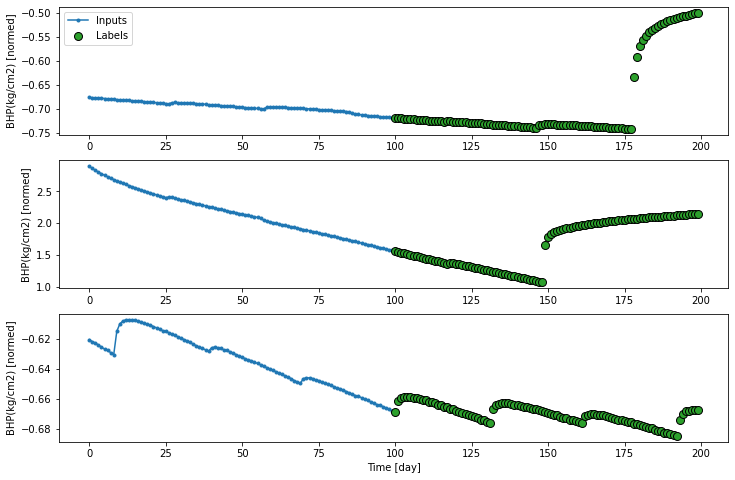

In [ ]:
OUT_STEPS = 100
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 100, 8)
Labels shape (batch, time, features): (32, 100, 8)


In [ ]:
num_features

8

***LSTM***

In [ ]:
# This returns a multi-layer-perceptron model in Keras.
def get_keras_model(num_hidden_layers,
                    num_neurons_per_layer):
    # create the MLP model.

    # define the layers.
    inputs = tf.keras.Input(shape=(100,8))               # input layer.

    # Add the hidden layers.
    for i in range(num_hidden_layers):
        x = tf.keras.layers.LSTM(num_neurons_per_layer,return_sequences=False)(inputs)

    # output layer.
    x = tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros())(x)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# This function takes in the hyperparameters and returns a score (Cross validation).
def keras_mlp_cv_score(parameterization, weight=None):

    model = get_keras_model(parameterization.get('num_hidden_layers'),
                            parameterization.get('neurons_per_layer'))

    opt = parameterization.get('optimizer')
    opt = opt.lower()

    learning_rate = parameterization.get('learning_rate')

    if opt == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif opt == 'rms':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    NUM_EPOCHS = 50

    # Specify the training configuration.
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    data = multi_window.train
    # fit the model using a 20% validation set.
    res = model.fit(data, epochs=NUM_EPOCHS, batch_size=parameterization.get('batch_size'),
                    validation_data=multi_window.val)

    # look at the last 10 epochs. Get the mean and standard deviation of the validation score.
    last10_scores = np.array(res.history['val_loss'][-10:])
    mean = last10_scores.mean()
    sem = last10_scores.std()

    # If the model didn't converge then set a high loss.
    if np.isnan(mean):
        return 9999.0, 0.0

    return mean, sem

In [ ]:
# Define the search space.
parameters=[
    {
        "name": "learning_rate",
        "type": "range",
        "bounds": [0.0001, 0.5],
        "log_scale": True,
    },
    {
        "name": "num_hidden_layers",
        "type": "range",
        "bounds": [1, 10],
        "value_type": "int"
    },
    {
        "name": "neurons_per_layer",
        "type": "range",
        "bounds": [1, 300],
        "value_type": "int"
    },
    {
        "name": "batch_size",
        "type": "choice",
        "values": [8, 16, 32, 64, 128, 256],
    },
    {
        "name": "optimizer",
        "type": "choice",
        "values": ['Nadam', 'rms', 'Adam'],
    },
]

In [ ]:
!pip install ax-platform

     |████████████████████████████████| 815 kB 34.6 MB/s 
     |████████████████████████████████| 475 kB 61.9 MB/s 
     |████████████████████████████████| 498 kB 68.7 MB/s 


In [ ]:
# import more packages
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting

init_notebook_plotting()

ax_client = AxClient()

# create the experiment.
ax_client.create_experiment(
    name="keras_experiment",
    parameters=parameters,
    objective_name='keras_cv',
    minimize=True)

def evaluate(parameters):
    return {"keras_cv": keras_mlp_cv_score(parameters)}

# Based on the search space, this will use Sobol (https://en.wikipedia.org/wiki/Sobol_sequence) instead of a Guassian Process (GPEI).
#
# From the source code:
#     """We should use only Sobol and not GPEI if:
#     1. there are less continuous parameters in the search space than the sum of
#     options for the choice parameters,
#     2. the number of total iterations in the optimization is known in advance and
#     there are less distinct points in the search space than the known intended
#     number of total iterations.
#     """

# Sobol sequences seem to be better than random for high-dimensional spaces:
# https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method

[INFO 07-17 11:04:07] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


[INFO 07-17 11:04:07] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 07-17 11:04:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-17 11:04:07] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-17 11:04:07] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter optimizer. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-17

In [ ]:
for i in range(25):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 07-17 11:04:19] ax.service.ax_client: Generated new trial 0 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 8, 'neurons_per_layer': 240, 'batch_size': 8, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.5242 - mean_absolute_error: 0.5793 - val_loss: 1.4509 - val_mean_absolute_error: 1.0244
Epoch 2/50
44/44 [==============================] - 1s 11ms/step - loss: 0.2861 - mean_absolute_error: 0.3781 - val_loss: 1.3808 - val_mean_absolute_error: 0.9769
Epoch 3/50
44/44 [==============================] - 1s 11ms/step - loss: 0.2291 - mean_absolute_error: 0.3068 - val_loss: 1.3599 - val_mean_absolute_error: 0.9605
Epoch 4/50
44/44 [==============================] - 1s 11ms/step - loss: 0.1954 - mean_absolute_error: 0.2580 - val_loss: 1.3899 - val_mean_absolute_error: 0.9791
Epoch 5/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1555 - mean_absolute_error: 0.1979 - val_loss: 1.4281 - val_mean_absolute_error: 1.0040
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.1318 - mean_absolute_error: 0.1744 - val_loss: 1.3949 - val_mean_absolute_error: 0.9829
Epoch 7/50
44/44 [====

[INFO 07-17 11:04:53] ax.service.ax_client: Completed trial 0 with data: {'keras_cv': (1.03, 0.02)}.
[INFO 07-17 11:04:53] ax.service.ax_client: Generated new trial 1 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 7, 'neurons_per_layer': 71, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.3081 - mean_absolute_error: 0.3839 - val_loss: 1.4060 - val_mean_absolute_error: 1.0163
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1452 - mean_absolute_error: 0.1967 - val_loss: 1.4020 - val_mean_absolute_error: 1.0031
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1187 - mean_absolute_error: 0.1603 - val_loss: 1.2348 - val_mean_absolute_error: 0.9166
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1113 - mean_absolute_error: 0.1454 - val_loss: 1.1820 - val_mean_absolute_error: 0.8755
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0702 - mean_absolute_error: 0.1119 - val_loss: 1.1596 - val_mean_absolute_error: 0.9063
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0395 - mean_absolute_error: 0.0825 - val_loss: 1.1656 - val_mean_absolute_error: 0.9040
Epoch 7/50
44/44 [====

[INFO 07-17 11:05:24] ax.service.ax_client: Completed trial 1 with data: {'keras_cv': (0.94, 0.02)}.
[INFO 07-17 11:05:24] ax.service.ax_client: Generated new trial 2 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 1, 'neurons_per_layer': 1, 'batch_size': 8, 'optimizer': 'Nadam'}.


Epoch 1/50
44/44 [==============================] - 2s 16ms/step - loss: 0.7007 - mean_absolute_error: 0.6885 - val_loss: 1.6772 - val_mean_absolute_error: 1.0791
Epoch 2/50
44/44 [==============================] - 0s 9ms/step - loss: 0.5001 - mean_absolute_error: 0.5539 - val_loss: 1.5252 - val_mean_absolute_error: 1.0379
Epoch 3/50
44/44 [==============================] - 0s 8ms/step - loss: 0.3587 - mean_absolute_error: 0.4604 - val_loss: 1.3795 - val_mean_absolute_error: 0.9810
Epoch 4/50
44/44 [==============================] - 0s 8ms/step - loss: 0.2854 - mean_absolute_error: 0.3835 - val_loss: 1.2840 - val_mean_absolute_error: 0.9218
Epoch 5/50
44/44 [==============================] - 0s 9ms/step - loss: 0.2529 - mean_absolute_error: 0.3383 - val_loss: 1.2456 - val_mean_absolute_error: 0.8850
Epoch 6/50
44/44 [==============================] - 0s 9ms/step - loss: 0.2414 - mean_absolute_error: 0.3259 - val_loss: 1.2536 - val_mean_absolute_error: 0.8755
Epoch 7/50
44/44 [=========

[INFO 07-17 11:05:52] ax.service.ax_client: Completed trial 2 with data: {'keras_cv': (1.34, 0.01)}.
[INFO 07-17 11:05:52] ax.service.ax_client: Generated new trial 3 with parameters {'learning_rate': 0.04, 'num_hidden_layers': 5, 'neurons_per_layer': 41, 'batch_size': 256, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 18ms/step - loss: 0.2445 - mean_absolute_error: 0.3025 - val_loss: 1.3644 - val_mean_absolute_error: 0.9555
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1043 - mean_absolute_error: 0.1841 - val_loss: 0.9764 - val_mean_absolute_error: 0.8375
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0717 - mean_absolute_error: 0.1505 - val_loss: 1.4595 - val_mean_absolute_error: 1.0172
Epoch 4/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0739 - mean_absolute_error: 0.1500 - val_loss: 1.4062 - val_mean_absolute_error: 0.9543
Epoch 5/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0530 - mean_absolute_error: 0.1299 - val_loss: 1.4510 - val_mean_absolute_error: 0.9864
Epoch 6/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0576 - mean_absolute_error: 0.1253 - val_loss: 1.0600 - val_mean_absolute_error: 0.7421
Epoch 7/50
44/44 [========

[INFO 07-17 11:06:22] ax.service.ax_client: Completed trial 3 with data: {'keras_cv': (1.57, 0.27)}.
[INFO 07-17 11:06:22] ax.service.ax_client: Generated new trial 4 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 6, 'neurons_per_layer': 228, 'batch_size': 128, 'optimizer': 'Nadam'}.


Epoch 1/50
44/44 [==============================] - 2s 21ms/step - loss: 0.1942 - mean_absolute_error: 0.2584 - val_loss: 1.0980 - val_mean_absolute_error: 0.8028
Epoch 2/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0750 - mean_absolute_error: 0.1485 - val_loss: 0.9592 - val_mean_absolute_error: 0.7649
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0365 - mean_absolute_error: 0.0907 - val_loss: 1.0388 - val_mean_absolute_error: 0.7662
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0288 - mean_absolute_error: 0.0720 - val_loss: 0.8633 - val_mean_absolute_error: 0.7269
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0251 - mean_absolute_error: 0.0637 - val_loss: 0.8370 - val_mean_absolute_error: 0.7118
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0233 - mean_absolute_error: 0.0597 - val_loss: 0.8334 - val_mean_absolute_error: 0.7089
Epoch 7/50
44/44 [====

[INFO 07-17 11:06:55] ax.service.ax_client: Completed trial 4 with data: {'keras_cv': (1.0, 0.13)}.
[INFO 07-17 11:07:02] ax.service.ax_client: Generated new trial 5 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 7, 'neurons_per_layer': 157, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.2112 - mean_absolute_error: 0.2786 - val_loss: 0.9986 - val_mean_absolute_error: 0.7866
Epoch 2/50
44/44 [==============================] - 1s 10ms/step - loss: 0.1306 - mean_absolute_error: 0.1852 - val_loss: 1.2127 - val_mean_absolute_error: 0.8886
Epoch 3/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0876 - mean_absolute_error: 0.1427 - val_loss: 1.2725 - val_mean_absolute_error: 0.8987
Epoch 4/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0552 - mean_absolute_error: 0.1144 - val_loss: 1.2538 - val_mean_absolute_error: 0.8991
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0385 - mean_absolute_error: 0.0926 - val_loss: 1.2233 - val_mean_absolute_error: 0.8279
Epoch 6/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0332 - mean_absolute_error: 0.0873 - val_loss: 1.2573 - val_mean_absolute_error: 0.9320
Epoch 7/50
44/44 [====

[INFO 07-17 11:07:35] ax.service.ax_client: Completed trial 5 with data: {'keras_cv': (0.87, 0.04)}.
[INFO 07-17 11:07:44] ax.service.ax_client: Generated new trial 6 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 5, 'neurons_per_layer': 159, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 21ms/step - loss: 0.2143 - mean_absolute_error: 0.2851 - val_loss: 1.2406 - val_mean_absolute_error: 0.9433
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 0.1161 - mean_absolute_error: 0.1721 - val_loss: 1.2462 - val_mean_absolute_error: 0.9252
Epoch 3/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0630 - mean_absolute_error: 0.1186 - val_loss: 1.1120 - val_mean_absolute_error: 0.8890
Epoch 4/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0445 - mean_absolute_error: 0.1014 - val_loss: 1.1412 - val_mean_absolute_error: 0.8756
Epoch 5/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0376 - mean_absolute_error: 0.0919 - val_loss: 1.0264 - val_mean_absolute_error: 0.8049
Epoch 6/50
44/44 [==============================] - 1s 13ms/step - loss: 0.0326 - mean_absolute_error: 0.0861 - val_loss: 1.1352 - val_mean_absolute_error: 0.8792
Epoch 7/50
44/44 [====

[INFO 07-17 11:08:17] ax.service.ax_client: Completed trial 6 with data: {'keras_cv': (0.95, 0.03)}.
[INFO 07-17 11:08:26] ax.service.ax_client: Generated new trial 7 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 8, 'neurons_per_layer': 134, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.4339 - mean_absolute_error: 0.4040 - val_loss: 1.3533 - val_mean_absolute_error: 0.9775
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1539 - mean_absolute_error: 0.2288 - val_loss: 1.3546 - val_mean_absolute_error: 1.0047
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0871 - mean_absolute_error: 0.1646 - val_loss: 1.6140 - val_mean_absolute_error: 1.0768
Epoch 4/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0792 - mean_absolute_error: 0.1453 - val_loss: 1.7304 - val_mean_absolute_error: 1.0925
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0459 - mean_absolute_error: 0.1172 - val_loss: 1.6431 - val_mean_absolute_error: 0.9795
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0382 - mean_absolute_error: 0.1048 - val_loss: 1.4896 - val_mean_absolute_error: 0.9798
Epoch 7/50
44/44 [====

[INFO 07-17 11:09:00] ax.service.ax_client: Completed trial 7 with data: {'keras_cv': (0.86, 0.04)}.
[INFO 07-17 11:09:10] ax.service.ax_client: Generated new trial 8 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 10, 'neurons_per_layer': 169, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.2021 - mean_absolute_error: 0.2776 - val_loss: 1.6883 - val_mean_absolute_error: 1.1147
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0793 - mean_absolute_error: 0.1494 - val_loss: 1.0144 - val_mean_absolute_error: 0.7624
Epoch 3/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0515 - mean_absolute_error: 0.1157 - val_loss: 1.2310 - val_mean_absolute_error: 0.9214
Epoch 4/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0507 - mean_absolute_error: 0.1108 - val_loss: 1.3933 - val_mean_absolute_error: 0.9526
Epoch 5/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0364 - mean_absolute_error: 0.0938 - val_loss: 1.1265 - val_mean_absolute_error: 0.8632
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0327 - mean_absolute_error: 0.0901 - val_loss: 1.1330 - val_mean_absolute_error: 0.8397
Epoch 7/50
44/44 [====

[INFO 07-17 11:09:43] ax.service.ax_client: Completed trial 8 with data: {'keras_cv': (0.88, 0.06)}.
[INFO 07-17 11:09:52] ax.service.ax_client: Generated new trial 9 with parameters {'learning_rate': 0.02, 'num_hidden_layers': 8, 'neurons_per_layer': 224, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 21ms/step - loss: 0.4141 - mean_absolute_error: 0.4253 - val_loss: 2.2359 - val_mean_absolute_error: 1.3316
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 0.1593 - mean_absolute_error: 0.2328 - val_loss: 1.5091 - val_mean_absolute_error: 1.0625
Epoch 3/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0743 - mean_absolute_error: 0.1675 - val_loss: 1.1759 - val_mean_absolute_error: 0.8759
Epoch 4/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0675 - mean_absolute_error: 0.1471 - val_loss: 1.3788 - val_mean_absolute_error: 0.9874
Epoch 5/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0607 - mean_absolute_error: 0.1299 - val_loss: 1.4285 - val_mean_absolute_error: 0.9056
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0469 - mean_absolute_error: 0.1156 - val_loss: 0.8895 - val_mean_absolute_error: 0.7522
Epoch 7/50
44/44 [====

[INFO 07-17 11:10:27] ax.service.ax_client: Completed trial 9 with data: {'keras_cv': (1.51, 0.2)}.
[INFO 07-17 11:10:42] ax.service.ax_client: Generated new trial 10 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 9, 'neurons_per_layer': 125, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.2065 - mean_absolute_error: 0.2742 - val_loss: 1.1936 - val_mean_absolute_error: 0.9080
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1184 - mean_absolute_error: 0.1713 - val_loss: 0.9631 - val_mean_absolute_error: 0.7543
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0700 - mean_absolute_error: 0.1245 - val_loss: 1.2526 - val_mean_absolute_error: 0.9343
Epoch 4/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0416 - mean_absolute_error: 0.1006 - val_loss: 1.2603 - val_mean_absolute_error: 0.9341
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0364 - mean_absolute_error: 0.0900 - val_loss: 1.2341 - val_mean_absolute_error: 0.9021
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0403 - mean_absolute_error: 0.0869 - val_loss: 1.1990 - val_mean_absolute_error: 0.8998
Epoch 7/50
44/44 [======

[INFO 07-17 11:11:13] ax.service.ax_client: Completed trial 10 with data: {'keras_cv': (0.89, 0.04)}.
[INFO 07-17 11:11:28] ax.service.ax_client: Generated new trial 11 with parameters {'learning_rate': 0.02, 'num_hidden_layers': 6, 'neurons_per_layer': 83, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.3570 - mean_absolute_error: 0.3688 - val_loss: 1.2992 - val_mean_absolute_error: 0.8515
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1515 - mean_absolute_error: 0.2497 - val_loss: 1.4826 - val_mean_absolute_error: 1.0214
Epoch 3/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1026 - mean_absolute_error: 0.1934 - val_loss: 1.5776 - val_mean_absolute_error: 1.0024
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0664 - mean_absolute_error: 0.1515 - val_loss: 1.2033 - val_mean_absolute_error: 0.8409
Epoch 5/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0548 - mean_absolute_error: 0.1293 - val_loss: 1.2520 - val_mean_absolute_error: 0.9017
Epoch 6/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0506 - mean_absolute_error: 0.1187 - val_loss: 1.1894 - val_mean_absolute_error: 0.8652
Epoch 7/50
44/44 [====

[INFO 07-17 11:12:01] ax.service.ax_client: Completed trial 11 with data: {'keras_cv': (1.67, 0.17)}.
[INFO 07-17 11:12:27] ax.service.ax_client: Generated new trial 12 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 9, 'neurons_per_layer': 148, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.2369 - mean_absolute_error: 0.2931 - val_loss: 1.3628 - val_mean_absolute_error: 0.9615
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1135 - mean_absolute_error: 0.1824 - val_loss: 1.1901 - val_mean_absolute_error: 0.9199
Epoch 3/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0550 - mean_absolute_error: 0.1251 - val_loss: 1.2134 - val_mean_absolute_error: 0.9203
Epoch 4/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0515 - mean_absolute_error: 0.1148 - val_loss: 1.2400 - val_mean_absolute_error: 0.8814
Epoch 5/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0461 - mean_absolute_error: 0.1006 - val_loss: 1.4074 - val_mean_absolute_error: 0.9350
Epoch 6/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0355 - mean_absolute_error: 0.0910 - val_loss: 0.8386 - val_mean_absolute_error: 0.6942
Epoch 7/50
44/44 [====

[INFO 07-17 11:13:01] ax.service.ax_client: Completed trial 12 with data: {'keras_cv': (0.86, 0.03)}.
[INFO 07-17 11:13:24] ax.service.ax_client: Generated new trial 13 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 7, 'neurons_per_layer': 101, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.5782 - mean_absolute_error: 0.6196 - val_loss: 1.5316 - val_mean_absolute_error: 1.0510
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.3193 - mean_absolute_error: 0.4149 - val_loss: 1.3399 - val_mean_absolute_error: 0.9733
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 0.2392 - mean_absolute_error: 0.3267 - val_loss: 1.3375 - val_mean_absolute_error: 0.9720
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.2031 - mean_absolute_error: 0.2726 - val_loss: 1.3416 - val_mean_absolute_error: 0.9758
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1704 - mean_absolute_error: 0.2142 - val_loss: 1.3270 - val_mean_absolute_error: 0.9703
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1477 - mean_absolute_error: 0.1839 - val_loss: 1.2929 - val_mean_absolute_error: 0.9473
Epoch 7/50
44/44 [=====

[INFO 07-17 11:13:56] ax.service.ax_client: Completed trial 13 with data: {'keras_cv': (1.0, 0.01)}.
[INFO 07-17 11:14:20] ax.service.ax_client: Generated new trial 14 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 7, 'neurons_per_layer': 139, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.2140 - mean_absolute_error: 0.2823 - val_loss: 1.4556 - val_mean_absolute_error: 0.9934
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1268 - mean_absolute_error: 0.1855 - val_loss: 1.2451 - val_mean_absolute_error: 0.8682
Epoch 3/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0864 - mean_absolute_error: 0.1434 - val_loss: 1.1217 - val_mean_absolute_error: 0.8378
Epoch 4/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0433 - mean_absolute_error: 0.1080 - val_loss: 1.3214 - val_mean_absolute_error: 0.9580
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0839 - mean_absolute_error: 0.1255 - val_loss: 1.0521 - val_mean_absolute_error: 0.8024
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0354 - mean_absolute_error: 0.0937 - val_loss: 1.0979 - val_mean_absolute_error: 0.8504
Epoch 7/50
44/44 [====

[INFO 07-17 11:14:53] ax.service.ax_client: Completed trial 14 with data: {'keras_cv': (1.06, 0.05)}.
[INFO 07-17 11:15:24] ax.service.ax_client: Generated new trial 15 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 10, 'neurons_per_layer': 138, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 3s 19ms/step - loss: 0.4746 - mean_absolute_error: 0.4105 - val_loss: 1.1762 - val_mean_absolute_error: 0.8470
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1610 - mean_absolute_error: 0.2436 - val_loss: 1.6608 - val_mean_absolute_error: 1.1066
Epoch 3/50
44/44 [==============================] - 1s 12ms/step - loss: 0.1391 - mean_absolute_error: 0.2097 - val_loss: 1.7216 - val_mean_absolute_error: 1.1137
Epoch 4/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0803 - mean_absolute_error: 0.1542 - val_loss: 1.1898 - val_mean_absolute_error: 0.8879
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0518 - mean_absolute_error: 0.1239 - val_loss: 1.5067 - val_mean_absolute_error: 0.8956
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0524 - mean_absolute_error: 0.1242 - val_loss: 1.1331 - val_mean_absolute_error: 0.8790
Epoch 7/50
44/44 [====

[INFO 07-17 11:15:58] ax.service.ax_client: Completed trial 15 with data: {'keras_cv': (0.75, 0.06)}.
[INFO 07-17 11:16:31] ax.service.ax_client: Generated new trial 16 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 8, 'neurons_per_layer': 165, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.3078 - mean_absolute_error: 0.3879 - val_loss: 1.3238 - val_mean_absolute_error: 0.9609
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 0.1540 - mean_absolute_error: 0.2094 - val_loss: 1.1896 - val_mean_absolute_error: 0.8947
Epoch 3/50
44/44 [==============================] - 1s 11ms/step - loss: 0.1207 - mean_absolute_error: 0.1695 - val_loss: 1.2222 - val_mean_absolute_error: 0.9075
Epoch 4/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0901 - mean_absolute_error: 0.1384 - val_loss: 1.3074 - val_mean_absolute_error: 0.9618
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0578 - mean_absolute_error: 0.1083 - val_loss: 1.3014 - val_mean_absolute_error: 0.9420
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0394 - mean_absolute_error: 0.0865 - val_loss: 1.1762 - val_mean_absolute_error: 0.8784
Epoch 7/50
44/44 [====

[INFO 07-17 11:17:04] ax.service.ax_client: Completed trial 16 with data: {'keras_cv': (0.9, 0.02)}.
[INFO 07-17 11:17:38] ax.service.ax_client: Generated new trial 17 with parameters {'learning_rate': 0.03, 'num_hidden_layers': 10, 'neurons_per_layer': 148, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.5006 - mean_absolute_error: 0.4475 - val_loss: 1.2321 - val_mean_absolute_error: 0.9076
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 0.1452 - mean_absolute_error: 0.2448 - val_loss: 1.3691 - val_mean_absolute_error: 1.0080
Epoch 3/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0842 - mean_absolute_error: 0.1797 - val_loss: 1.5130 - val_mean_absolute_error: 0.9420
Epoch 4/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0798 - mean_absolute_error: 0.1702 - val_loss: 1.2020 - val_mean_absolute_error: 0.9644
Epoch 5/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0603 - mean_absolute_error: 0.1440 - val_loss: 1.2591 - val_mean_absolute_error: 0.9406
Epoch 6/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0486 - mean_absolute_error: 0.1255 - val_loss: 0.8768 - val_mean_absolute_error: 0.7579
Epoch 7/50
44/44 [====

[INFO 07-17 11:18:12] ax.service.ax_client: Completed trial 17 with data: {'keras_cv': (1.22, 0.33)}.
[INFO 07-17 11:18:42] ax.service.ax_client: Generated new trial 18 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 10, 'neurons_per_layer': 128, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.3129 - mean_absolute_error: 0.3672 - val_loss: 1.4840 - val_mean_absolute_error: 1.0481
Epoch 2/50
44/44 [==============================] - 1s 11ms/step - loss: 0.1513 - mean_absolute_error: 0.2361 - val_loss: 1.2688 - val_mean_absolute_error: 0.9240
Epoch 3/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0769 - mean_absolute_error: 0.1574 - val_loss: 1.4089 - val_mean_absolute_error: 0.9758
Epoch 4/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0509 - mean_absolute_error: 0.1288 - val_loss: 1.3267 - val_mean_absolute_error: 0.9880
Epoch 5/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0491 - mean_absolute_error: 0.1153 - val_loss: 1.3832 - val_mean_absolute_error: 0.9226
Epoch 6/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0367 - mean_absolute_error: 0.0983 - val_loss: 1.1939 - val_mean_absolute_error: 0.8710
Epoch 7/50
44/44 [====

[INFO 07-17 11:19:16] ax.service.ax_client: Completed trial 18 with data: {'keras_cv': (0.78, 0.03)}.
[INFO 07-17 11:19:50] ax.service.ax_client: Generated new trial 19 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 10, 'neurons_per_layer': 75, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.3387 - mean_absolute_error: 0.4185 - val_loss: 1.2804 - val_mean_absolute_error: 0.9504
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1557 - mean_absolute_error: 0.2148 - val_loss: 1.2158 - val_mean_absolute_error: 0.9258
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1221 - mean_absolute_error: 0.1706 - val_loss: 1.2966 - val_mean_absolute_error: 0.9585
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1123 - mean_absolute_error: 0.1515 - val_loss: 1.0600 - val_mean_absolute_error: 0.8189
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1066 - mean_absolute_error: 0.1436 - val_loss: 1.2778 - val_mean_absolute_error: 0.9437
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0976 - mean_absolute_error: 0.1338 - val_loss: 1.2106 - val_mean_absolute_error: 0.8941
Epoch 7/50
44/44 [====

[INFO 07-17 11:20:22] ax.service.ax_client: Completed trial 19 with data: {'keras_cv': (0.94, 0.02)}.
[INFO 07-17 11:20:58] ax.service.ax_client: Generated new trial 20 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 10, 'neurons_per_layer': 142, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 21ms/step - loss: 0.4259 - mean_absolute_error: 0.3884 - val_loss: 1.3524 - val_mean_absolute_error: 0.8923
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 0.1274 - mean_absolute_error: 0.2063 - val_loss: 1.6720 - val_mean_absolute_error: 1.0612
Epoch 3/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0723 - mean_absolute_error: 0.1540 - val_loss: 1.2077 - val_mean_absolute_error: 0.9087
Epoch 4/50
44/44 [==============================] - 1s 13ms/step - loss: 0.0487 - mean_absolute_error: 0.1238 - val_loss: 1.3734 - val_mean_absolute_error: 0.9368
Epoch 5/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0430 - mean_absolute_error: 0.1082 - val_loss: 1.2122 - val_mean_absolute_error: 0.8835
Epoch 6/50
44/44 [==============================] - 1s 13ms/step - loss: 0.0437 - mean_absolute_error: 0.1016 - val_loss: 1.1015 - val_mean_absolute_error: 0.8580
Epoch 7/50
44/44 [====

[INFO 07-17 11:21:32] ax.service.ax_client: Completed trial 20 with data: {'keras_cv': (0.71, 0.02)}.
[INFO 07-17 11:22:22] ax.service.ax_client: Generated new trial 21 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 10, 'neurons_per_layer': 149, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.4446 - mean_absolute_error: 0.4582 - val_loss: 1.8882 - val_mean_absolute_error: 1.0828
Epoch 2/50
44/44 [==============================] - 1s 11ms/step - loss: 0.1186 - mean_absolute_error: 0.2177 - val_loss: 1.5002 - val_mean_absolute_error: 0.9102
Epoch 3/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0707 - mean_absolute_error: 0.1647 - val_loss: 1.2502 - val_mean_absolute_error: 0.9054
Epoch 4/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0531 - mean_absolute_error: 0.1350 - val_loss: 1.4097 - val_mean_absolute_error: 0.8643
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0426 - mean_absolute_error: 0.1185 - val_loss: 1.1463 - val_mean_absolute_error: 0.8743
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0405 - mean_absolute_error: 0.1080 - val_loss: 1.2236 - val_mean_absolute_error: 0.8660
Epoch 7/50
44/44 [====

[INFO 07-17 11:22:57] ax.service.ax_client: Completed trial 21 with data: {'keras_cv': (0.95, 0.07)}.
[INFO 07-17 11:24:59] ax.service.ax_client: Generated new trial 22 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 10, 'neurons_per_layer': 138, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.2642 - mean_absolute_error: 0.3285 - val_loss: 1.1975 - val_mean_absolute_error: 0.8612
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 0.1292 - mean_absolute_error: 0.1898 - val_loss: 1.5733 - val_mean_absolute_error: 1.0552
Epoch 3/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0696 - mean_absolute_error: 0.1370 - val_loss: 1.5553 - val_mean_absolute_error: 1.0733
Epoch 4/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0500 - mean_absolute_error: 0.1130 - val_loss: 1.0500 - val_mean_absolute_error: 0.8428
Epoch 5/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0421 - mean_absolute_error: 0.1046 - val_loss: 1.2782 - val_mean_absolute_error: 0.9108
Epoch 6/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0389 - mean_absolute_error: 0.0968 - val_loss: 1.2095 - val_mean_absolute_error: 0.9145
Epoch 7/50
44/44 [====

[INFO 07-17 11:25:33] ax.service.ax_client: Completed trial 22 with data: {'keras_cv': (0.89, 0.02)}.
[INFO 07-17 11:26:46] ax.service.ax_client: Generated new trial 23 with parameters {'learning_rate': 0.0, 'num_hidden_layers': 8, 'neurons_per_layer': 127, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 20ms/step - loss: 0.2742 - mean_absolute_error: 0.3458 - val_loss: 1.3619 - val_mean_absolute_error: 0.9652
Epoch 2/50
44/44 [==============================] - 1s 11ms/step - loss: 0.1390 - mean_absolute_error: 0.1897 - val_loss: 1.2637 - val_mean_absolute_error: 0.9377
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1049 - mean_absolute_error: 0.1536 - val_loss: 1.3090 - val_mean_absolute_error: 0.9286
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0626 - mean_absolute_error: 0.1150 - val_loss: 1.2572 - val_mean_absolute_error: 0.8999
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0432 - mean_absolute_error: 0.0924 - val_loss: 1.2175 - val_mean_absolute_error: 0.8898
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0398 - mean_absolute_error: 0.0880 - val_loss: 1.1751 - val_mean_absolute_error: 0.8669
Epoch 7/50
44/44 [====

[INFO 07-17 11:27:20] ax.service.ax_client: Completed trial 23 with data: {'keras_cv': (0.89, 0.02)}.
[INFO 07-17 11:28:13] ax.service.ax_client: Generated new trial 24 with parameters {'learning_rate': 0.01, 'num_hidden_layers': 10, 'neurons_per_layer': 106, 'batch_size': 64, 'optimizer': 'rms'}.


Epoch 1/50
44/44 [==============================] - 2s 21ms/step - loss: 0.2862 - mean_absolute_error: 0.3211 - val_loss: 1.8401 - val_mean_absolute_error: 1.1812
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1193 - mean_absolute_error: 0.1920 - val_loss: 1.6977 - val_mean_absolute_error: 1.0889
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0725 - mean_absolute_error: 0.1429 - val_loss: 2.1609 - val_mean_absolute_error: 1.1128
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0647 - mean_absolute_error: 0.1290 - val_loss: 1.7745 - val_mean_absolute_error: 1.1345
Epoch 5/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0456 - mean_absolute_error: 0.1094 - val_loss: 1.0774 - val_mean_absolute_error: 0.8130
Epoch 6/50
44/44 [==============================] - 1s 11ms/step - loss: 0.0416 - mean_absolute_error: 0.1013 - val_loss: 1.7774 - val_mean_absolute_error: 1.0531
Epoch 7/50
44/44 [====

[INFO 07-17 11:28:47] ax.service.ax_client: Completed trial 24 with data: {'keras_cv': (0.74, 0.05)}.


In [ ]:
# look at all the trials.
ax_client.get_trials_data_frame().sort_values('trial_index')

keras_cv  trial_index arm_name  ...  optimizer  trial_status  generator_model
0   1.025279            0      0_0  ...        rms     COMPLETED            Sobol
3   0.938023            1      1_0  ...        rms     COMPLETED            Sobol
15  1.342902            2      2_0  ...      Nadam     COMPLETED            Sobol
18  1.573113            3      3_0  ...        rms     COMPLETED            Sobol
19  1.000807            4      4_0  ...      Nadam     COMPLETED            Sobol
20  0.866153            5      5_0  ...        rms     COMPLETED         BO_MIXED
21  0.948933            6      6_0  ...        rms     COMPLETED         BO_MIXED
22  0.857246            7      7_0  ...        rms     COMPLETED         BO_MIXED
23  0.877823            8      8_0  ...        rms     COMPLETED         BO_MIXED
24  1.506885            9      9_0  ...        rms     COMPLETED         BO_MIXED
1   0.893071           10     10_0  ...        rms     COMPLETED         BO_MIXED
2   1.670387           11     11_0  ...        rms     COMPLETED         BO_MIXED
4   0.856553           12     12_0  ...        rms     COMPLETED         BO_MIXED
5   1.004020           13     13_0  ...        rms     COMPLETED         BO_MIXED
6   1.063448           14     14_0  ...        rms     COMPLETED         BO_MIXED
7   0.748411           15     15_0  ...        rms     COMPLETED         BO_MIXED
8   0.896985           16     16_0  ...        rms     COMPLETED         BO_MIXED
9   1.215003           17     17_0  ...        rms     COMPLETED         BO_MIXED
10  0.778664           18     18_0  ...        rms     COMPLETED         BO_MIXED
11  0.942880           19     19_0  ...        rms     COMPLETED         BO_MIXED
12  0.708712           20     20_0  ...        rms     COMPLETED         BO_MIXED
13  0.949983           21     21_0  ...        rms     COMPLETED         BO_MIXED
14  0.894569           22     22_0  ...        rms     COMPLETED         BO_MIXED
16  0.890437           23     23_0  ...        rms     COMPLETED         BO_MIXED
17  0.740214           24     24_0  ...        rms     COMPLETED         BO_MIXED

[25 rows x 10 columns]

In [ ]:
best_parameters, values = ax_client.get_best_parameters()

# the best set of parameters.
for k in best_parameters.items():
  print(k)

print()

# the best score achieved.
means, covariances = values
print(means)

('learning_rate', 0.008436488966351482)
('num_hidden_layers', 10)
('neurons_per_layer', 142)
('batch_size', 64)
('optimizer', 'rms')

{'keras_cv': 0.7087124407291412}


In [ ]:
# train the model on the full training set and test.
dense_model = get_keras_model(best_parameters['num_hidden_layers'],
                              best_parameters['neurons_per_layer'])

opt = best_parameters['optimizer']
opt = opt.lower()

learning_rate = best_parameters['learning_rate']

if opt == 'Nadam':
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
elif opt == 'rms':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

NUM_EPOCHS = 50

# Specify the training configuration.
dense_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.metrics.MeanAbsoluteError()])

data = multi_window.train
res = dense_model.fit(data, epochs=NUM_EPOCHS, batch_size=best_parameters['batch_size'],validation_data=multi_window.val)

Epoch 1/50
44/44 [==============================] - 2s 19ms/step - loss: 0.4008 - mean_absolute_error: 0.3759 - val_loss: 1.6149 - val_mean_absolute_error: 1.0721
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 0.1251 - mean_absolute_error: 0.1958 - val_loss: 1.6756 - val_mean_absolute_error: 1.1155
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0948 - mean_absolute_error: 0.1646 - val_loss: 1.4872 - val_mean_absolute_error: 1.0064
Epoch 4/50
44/44 [==============================] - 0s 11ms/step - loss: 0.0935 - mean_absolute_error: 0.1571 - val_loss: 1.7319 - val_mean_absolute_error: 0.9319
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0538 - mean_absolute_error: 0.1175 - val_loss: 1.4979 - val_mean_absolute_error: 0.9944
Epoch 6/50
44/44 [==============================] - 1s 12ms/step - loss: 0.0504 - mean_absolute_error: 0.1143 - val_loss: 1.0615 - val_mean_absolute_error: 0.8022
Epoch 7/50
44/44 [====

In [ ]:
val_performance = {}
performance = {}

In [ ]:
# Use the model to predict the test values.
performance['LSTM'] = dense_model.evaluate(multi_window.test)

1/1 [==============================] - 0s 41ms/step - loss: 2.2162 - mean_absolute_error: 1.3331


In [ ]:
val_performance['LSTM'] = dense_model.evaluate(multi_window.val)

8/8 [==============================] - 0s 5ms/step - loss: 0.9155 - mean_absolute_error: 0.7986


In [ ]:
multi_window.plot(dense_model)

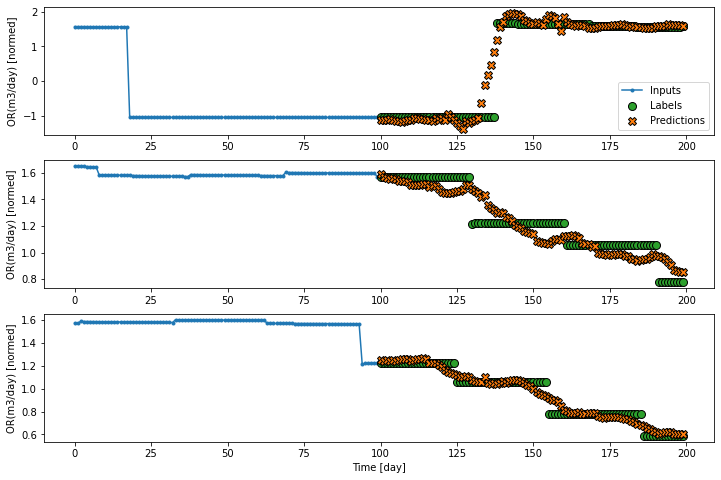

In [ ]:
multi_window.plot(dense_model , plot_col='OR(m3/day)')

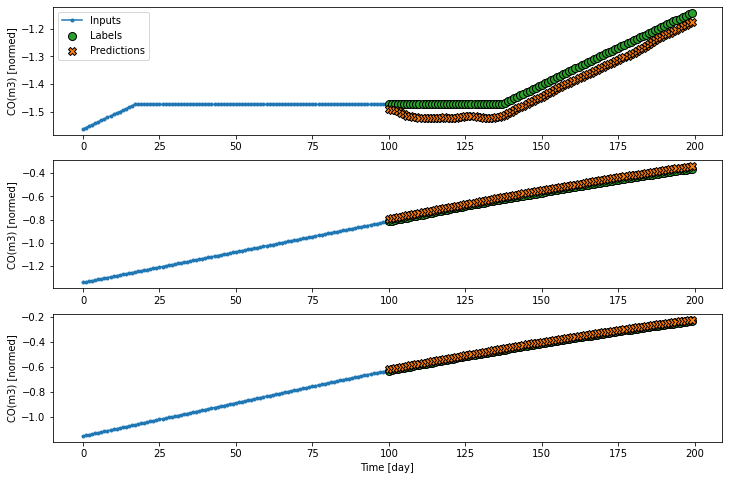

In [ ]:
multi_window.plot(dense_model , plot_col='CO(m3)')

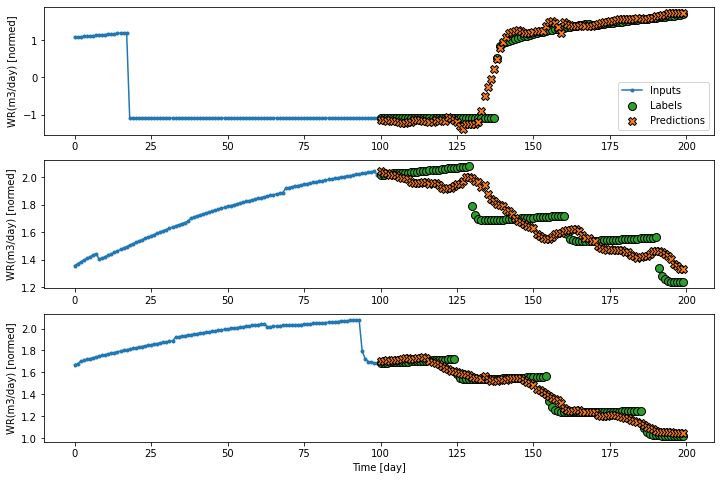

In [ ]:
multi_window.plot(dense_model , plot_col='WR(m3/day)')

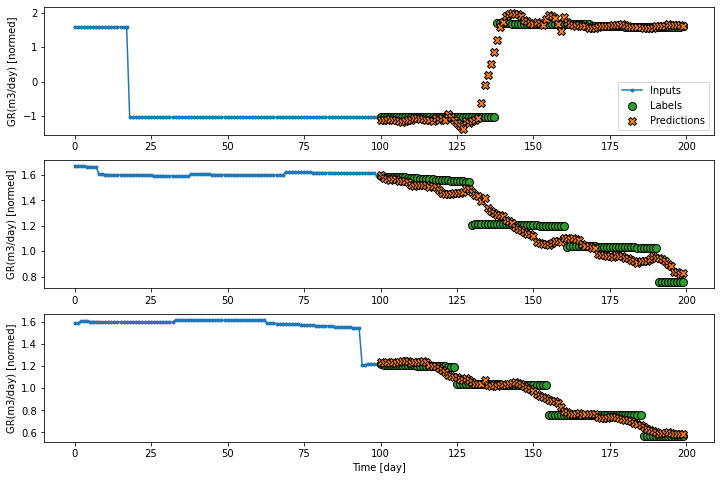

In [ ]:
multi_window.plot(dense_model , plot_col='GR(m3/day)')

***Autoregressive model***

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=142, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 8])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 100, 8)


In [ ]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=50):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0008),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(feedback_model, multi_window)
#performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
#performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
#multi_window.plot(feedback_model)

Epoch 1/50
44/44 [==============================] - 25s 247ms/step - loss: 0.0123 - mean_absolute_error: 0.0375 - val_loss: 0.3800 - val_mean_absolute_error: 0.4210
Epoch 2/50
44/44 [==============================] - 8s 181ms/step - loss: 0.0097 - mean_absolute_error: 0.0304 - val_loss: 0.3858 - val_mean_absolute_error: 0.4320
Epoch 3/50
44/44 [==============================] - 8s 190ms/step - loss: 0.0090 - mean_absolute_error: 0.0280 - val_loss: 0.3900 - val_mean_absolute_error: 0.4392
Epoch 4/50
44/44 [==============================] - 8s 192ms/step - loss: 0.0075 - mean_absolute_error: 0.0263 - val_loss: 0.3776 - val_mean_absolute_error: 0.4337
Epoch 5/50
44/44 [==============================] - 9s 200ms/step - loss: 0.0106 - mean_absolute_error: 0.0281 - val_loss: 0.3811 - val_mean_absolute_error: 0.4366
Epoch 6/50
44/44 [==============================] - 9s 199ms/step - loss: 0.0077 - mean_absolute_error: 0.0258 - val_loss: 0.3861 - val_mean_absolute_error: 0.4409
Epoch 7/50
44/4

In [ ]:
performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test)

1/1 [==============================] - 0s 61ms/step - loss: 2.3435 - mean_absolute_error: 1.4490


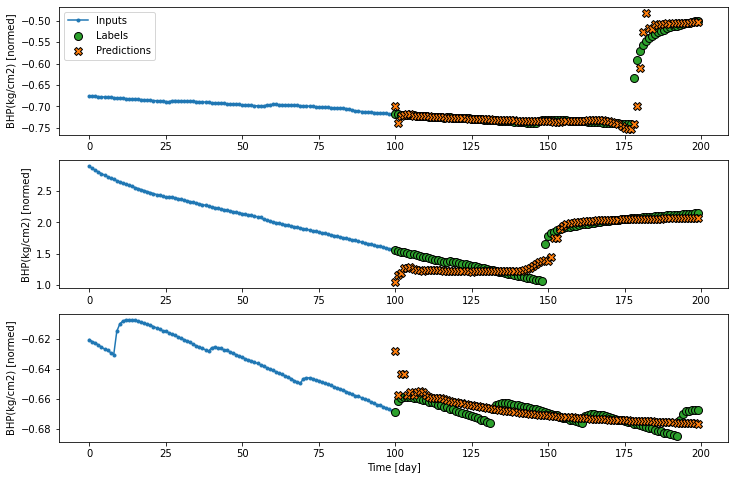

In [ ]:
multi_window.plot(feedback_model)

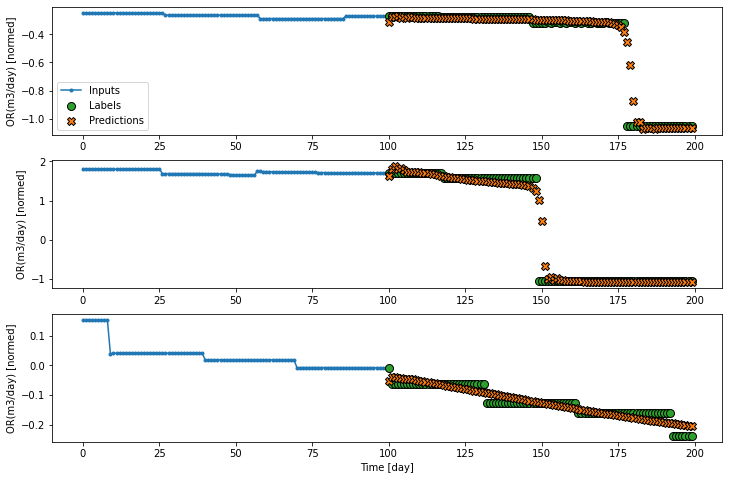

In [ ]:
multi_window.plot(feedback_model , plot_col='OR(m3/day)')

In [ ]:
multi_window.plot(feedback_model , plot_col='CO(m3)')

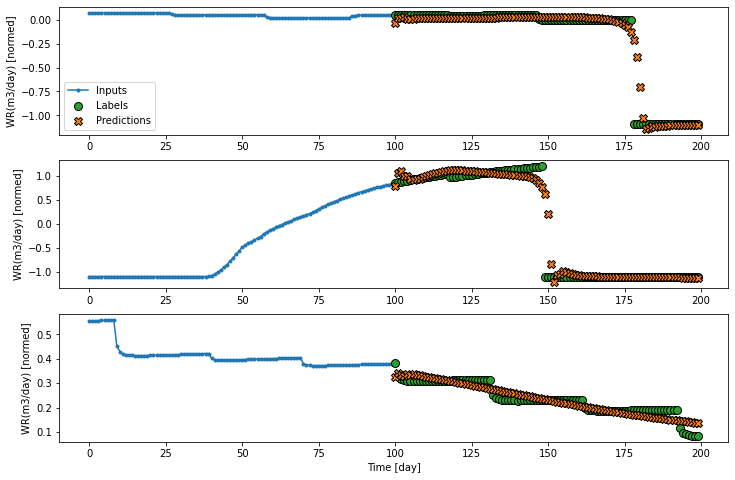

In [ ]:
multi_window.plot(feedback_model , plot_col='WR(m3/day)')

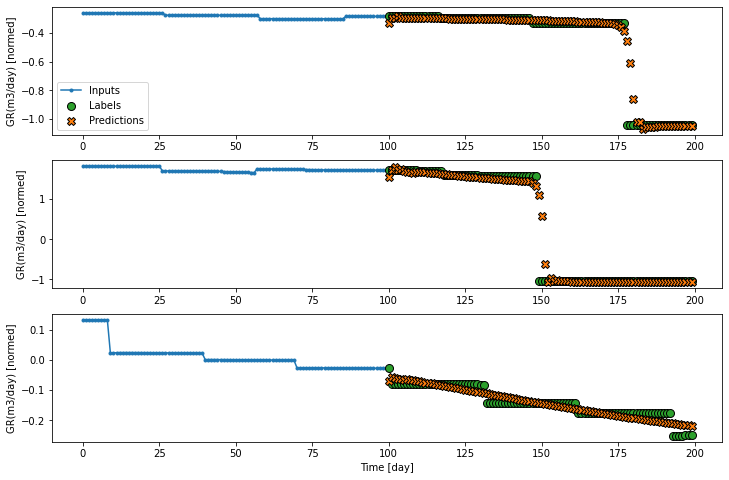

In [ ]:
multi_window.plot(feedback_model , plot_col='GR(m3/day)')